In [6]:
# Импорт библиотек
import os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Descriptors, Crippen, AllChem
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
import pickle

import torch
from Bio.PDB import PDBParser
from openbabel import pybel
import requests
from rdkit.Chem import Draw
from tqdm import tqdm
import sklearn
import joblib
import xgboost
import lightgbm

# Настройки
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [7]:
# Загрузка PDB файла (если еще не загружен)
def download_pdb_file(pdb_id="4L7B"):
    print(f"[*] Загрузка PDB файла для KEAP1 ({pdb_id})...")
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    with open(f"data/{pdb_id}.pdb", "wb") as f:
        f.write(response.content)
    print(f"[+] PDB файл сохранен: data/{pdb_id}.pdb")

download_pdb_file(pdb_id="4L7B")

[*] Загрузка PDB файла для KEAP1 (4L7B)...
[+] PDB файл сохранен: data/4L7B.pdb


In [8]:
# De Novo генерация молекул для KEAP1
print("[*] Запускаю De Novo генерацию молекул для кармана KEAP1 (PDB: 4L7B)...")
pdb_file = "data/4L7B.pdb"
checkpoint_file = "checkpoints/crossdocked_fullatom_cond.ckpt"
output_file = "data/keap1_generated_denovo.sdf"
ref_ligand = "B:701"  # Корректный идентификатор кармана
n_samples = 50

!python generate_ligands.py {checkpoint_file} --pdbfile {pdb_file} --outfile {output_file} --ref_ligand {ref_ligand} --n_samples {n_samples} --sanitize
print(f"\n[+] Генерация завершена. Молекулы сохранены в {output_file}")

[*] Запускаю De Novo генерацию молекул для кармана KEAP1 (PDB: 4L7B)...


In [9]:
from openbabel import pybel
mols = [m for m in pybel.readfile("sdf", "data/keap1_generated_denovo.sdf")]
print(f"Количество успешных молекул: {len(mols)}")

Количество успешных молекул: 49


In [10]:
# Чтение и обработка сгенерированных молекул
def read_sdf_file(sdf_file):
    print("[*] Чтение сгенерированных молекул...")
    mols = [m for m in pybel.readfile("sdf", sdf_file)]
    smiles_list = [m.write("smi").split()[0] for m in mols]
    print(f"[+] Прочитано {len(smiles_list)} молекул.")
    return smiles_list

smiles_list = read_sdf_file(output_file)

[*] Чтение сгенерированных молекул...
[+] Прочитано 49 молекул.


Найдено молекул: 49


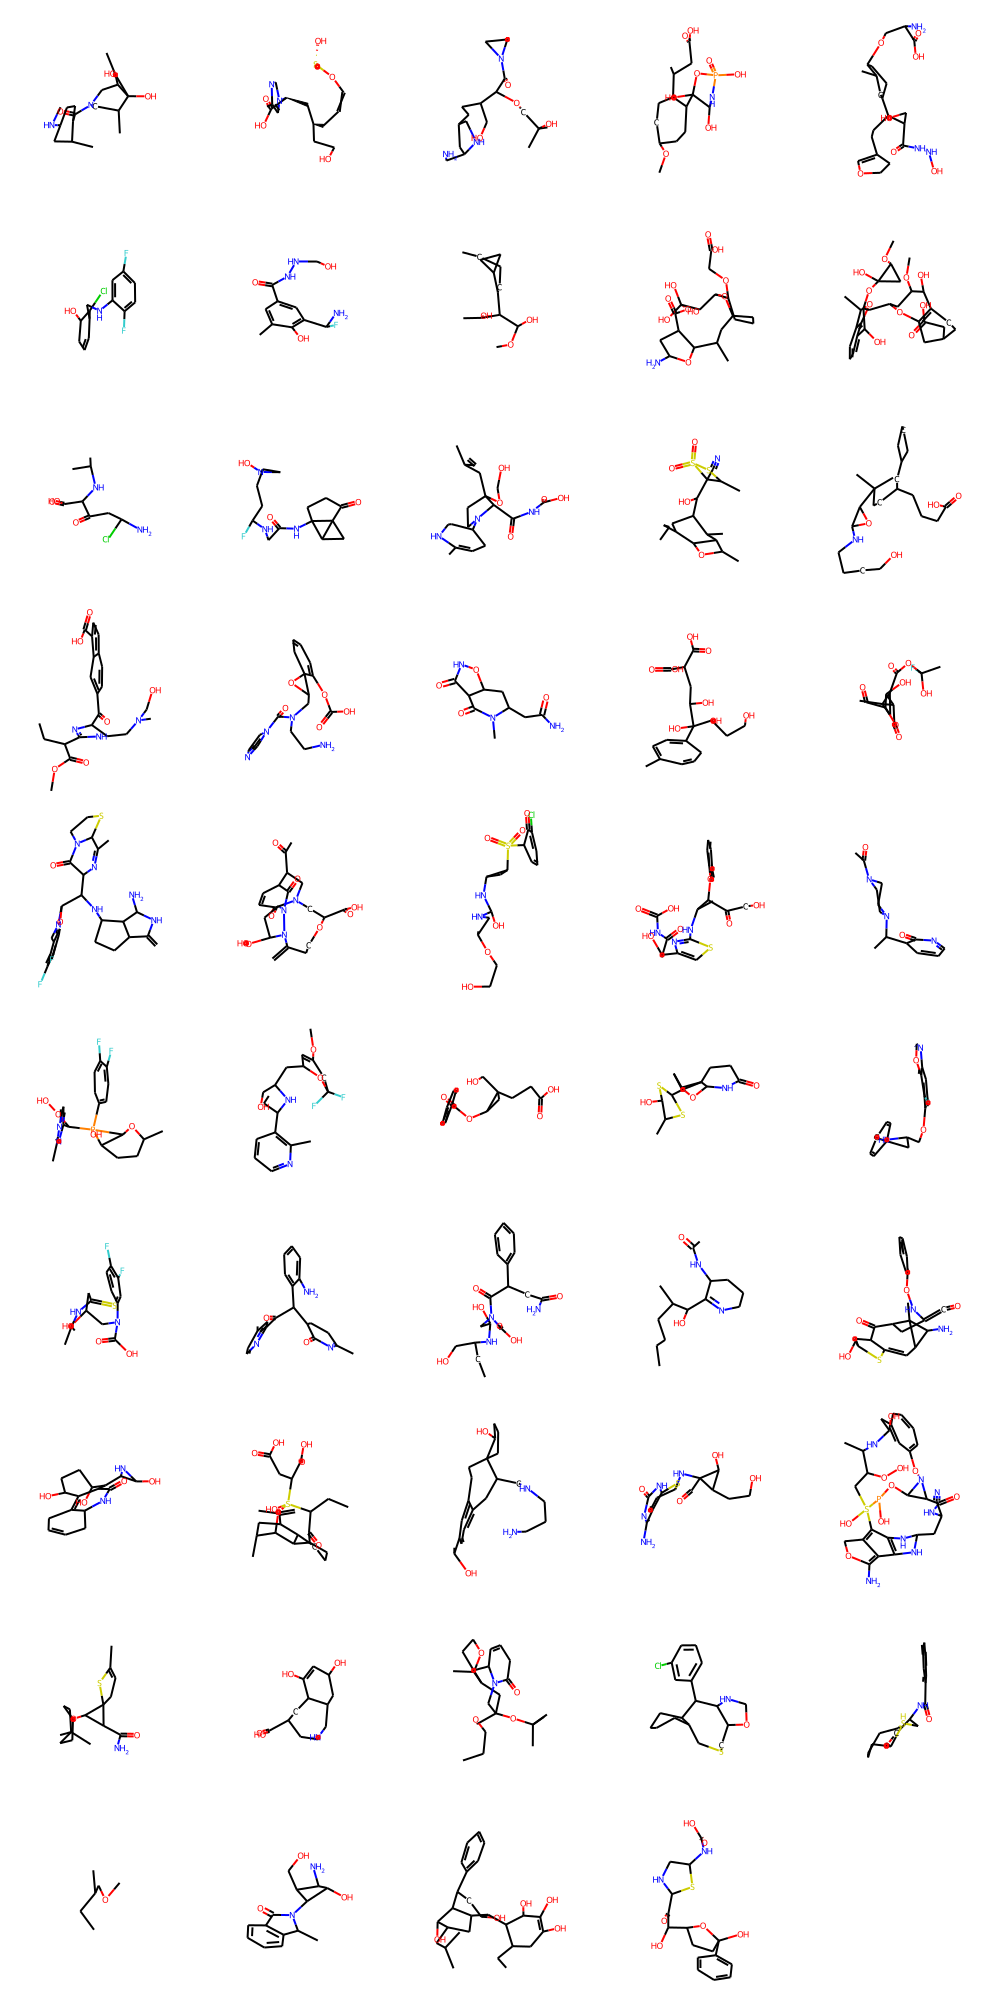

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
suppl = Chem.SDMolSupplier("data/keap1_generated_denovo.sdf")
mols = [mol for mol in suppl if mol is not None]
print(f"Найдено молекул: {len(mols)}")
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

In [13]:
# Расчет свойств молекул
from rdkit import Chem
from rdkit.Chem import RDConfig, Descriptors, QED, Crippen
from rdkit.Chem import rdFingerprintGenerator  # Добавлен импорт
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from tqdm import tqdm
import numpy as np

# Глобальный генератор Morgan fingerprints, соответствующий code.py
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def calculate_sa_score(mol):
    """Рассчитывает SA_Score, как в code.py."""
    try:
        return sascorer.calculateScore(mol)
    except:
        # Fallback SA Score approximation
        logp = Descriptors.MolLogP(mol)
        mw = Descriptors.MolWt(mol)
        rot_bonds = Descriptors.NumRotatableBonds(mol)
        score = 2.5 + 0.1 * (mw / 100) + 0.2 * rot_bonds + 0.3 * abs(logp - 2.5)
        return min(score, 10.0)

def calculate_cns_mpo(mol):
    """Рассчитывает CNS_MPO, как в code.py."""
    if mol is None:
        return 0.0
    props = [Descriptors.MolLogP(mol), Descriptors.TPSA(mol), Descriptors.MolWt(mol), Descriptors.NumHDonors(mol)]
    if any(p is None for p in props):
        return 0.0
    logp, tpsa, mw, hbd = props
    scores = [
        np.exp(-((logp - 2.5)**2) / 2),
        np.exp(-((tpsa - 75)**2) / (2 * 30**2)),
        np.exp(-((mw - 400)**2) / (2 * 100**2)),
        np.exp(-(hbd - 2.5)) if hbd > 2.5 else 1.0
    ]
    return np.mean(scores)

def check_lipinski(mol):
    """Проверка правил Липински, как в code.py."""
    if mol is None:
        return False
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)
    return mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10

def check_veber(mol):
    """Проверка правил Вебера, как в code.py."""
    if mol is None:
        return False
    tpsa = Descriptors.TPSA(mol)
    rot_bonds = Descriptors.NumRotatableBonds(mol)
    return tpsa <= 140 and rot_bonds <= 10

def has_pains(mol):
    """Проверка на PAINS, как в code.py."""
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
    catalog = FilterCatalog(params)
    return mol is not None and catalog.HasMatch(mol)

def check_valency(mol):
    """Проверка валентности, как в code.py."""
    try:
        Chem.SanitizeMol(mol, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL)
        return True
    except:
        return False

def calculate_properties(smiles_list, keap1_model, egfr_model, ikkb_model):
    """
    Рассчитывает свойства молекул, как в calculate_advanced_properties из code.py.

    Parameters:
    - smiles_list (list): Список SMILES строк.
    - keap1_model: Модель для предсказания pIC50 KEAP1.
    - egfr_model: Модель для предсказания pIC50 EGFR.
    - ikkb_model: Модель для предсказания pIC50 IKKβ.

    Returns:
    - pd.DataFrame: DataFrame с рассчитанными свойствами.
    """
    print("[*] Расчет свойств молекул...")
    properties_list = []

    for smiles in tqdm(smiles_list, desc="Оценка свойств"):
        try:
            mol = Chem.MolFromSmiles(smiles)
        except:
            continue
        if mol is None or not check_valency(mol) or has_pains(mol) or not check_lipinski(mol) or not check_veber(mol):
            continue

        # Генерация Morgan fingerprints и дескрипторов
        fp = np.array(morgan_gen.GetFingerprint(mol)).reshape(1, -1)
        desc_list = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.RingCount(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.HeavyAtomCount(mol)
        ]
        desc = np.array(desc_list).reshape(1, -1)
        features = np.hstack((fp, desc))

        # Расчет BBB_Score
        logp = Crippen.MolLogP(mol)
        tpsa = Descriptors.TPSA(mol)
        mw = Descriptors.MolWt(mol)
        hbd = Descriptors.NumHDonors(mol)
        hba = Descriptors.NumHAcceptors(mol)
        bbb_score = 1.0
        if not (1.0 <= logp <= 5.0):
            bbb_score *= 0.8
        if tpsa > 90:
            bbb_score *= 0.7
        if mw > 500:
            bbb_score *= 0.7
        if hbd > 5 or hba > 10:
            bbb_score *= 0.6

        # Сбор свойств
        result = {
            'SMILES': smiles,
            'QED': Descriptors.qed(mol),
            'CNS_MPO': calculate_cns_mpo(mol),
            'RingCount': Descriptors.RingCount(mol),
            'BBB_Score': bbb_score,
            'SA_Score': calculate_sa_score(mol)
        }

        # Предсказание pIC50
        try:
            result.update({
                'pIC50_KEAP1': keap1_model.predict(features)[0],
                'pIC50_EGFR': egfr_model.predict(features)[0],
                'pIC50_IKKb': ikkb_model.predict(features)[0],
                'Selectivity_Score': keap1_model.predict(features)[0] - max(egfr_model.predict(features)[0], ikkb_model.predict(features)[0])
            })
        except Exception as e:
            print(f"[!] Prediction error for SMILES {smiles}: {e}")
            result.update({
                'pIC50_KEAP1': 0.0,
                'pIC50_EGFR': 0.0,
                'pIC50_IKKb': 0.0,
                'Selectivity_Score': 0.0
            })

        properties_list.append(result)

    properties_df = pd.DataFrame(properties_list)
    print(f"[+] Количество обработанных молекул: {len(properties_df)}")
    return properties_df

# Загрузка моделей (предполагается, что они совместимы с code.py)
try:
    keap1_model = joblib.load('keap1_activity_model.pkl')
    print("Модель keap1 загружена через joblib")
except Exception as e:
    print(f"Ошибка joblib для keap1: {e}")

try:
    ikkb_model = joblib.load('ikkb_activity_model.pkl')
    print("Модель ikkb_model загружена через joblib")
except Exception as e:
    print(f"Ошибка joblib для ikkb_model: {e}")

try:
    egfr_model = joblib.load('egfr_activity_model.pkl')
    print("Модель egfr загружена через joblib")
except Exception as e:
    print(f"Ошибка joblib для egfr: {e}")

# Вызов функции для расчета свойств
properties_df = calculate_properties(smiles_list, keap1_model, egfr_model, ikkb_model)

/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator RandomForestRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/pickle.py:1718: UserWarning: [19:49:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

Модель keap1 загружена через joblib
Модель ikkb_model загружена через joblib
Модель egfr загружена через joblib
[*] Расчет свойств молекул...


Оценка свойств:   0%|                                     | 0/49 [00:00<?, ?it/s]/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
Оценка свойств:   2%|▌                            | 1/49 [00:00<00:19,  2.40it/s]/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/irene/anaconda3/envs/diffsbdd/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names

[+] Количество обработанных молекул: 37


In [14]:
print(properties_df)

                                               SMILES       QED   CNS_MPO  \
0   [C@@H]1([C@@H](C)C[C@H](NC)CC1)C(=O)N1C[C@H](C...  0.698316  0.609544   
1   O[S@@](=O)OC=CC[C@H](C[C@H](n1cnc(C)c1)C(=O)O)CCO  0.435340  0.540600   
2   O=C([C@H](OCC(C)(C)O)[C@H](CC[C@@H]1CN[C@@H](C...  0.399916  0.426551   
3          [C@H]1([C@H](CC=C[C@H]1CNc1cc(F)ccc1F)O)Cl  0.655565  0.682022   
4      [C@H]([C@H](O)C)([C@@H](C1CC1)CCCC)[C@@H](O)OC  0.628249  0.720750   
5                O=C(O)[C@@H](C(=O)C[C@H](N)Cl)NC(C)C  0.332198  0.423715   
6   [C@@H](F)(NCC(=O)N[C@]12[C@@H]3[C@]1(C(=O)CC2)...  0.453800  0.553530   
7   O(CO)[C@]1(CC[N@]([C@H]1C(=O)NC(=O)O)[C@H]1CCN...  0.389864  0.563333   
8   [C@H]1(O[C@H]2[C@@H](CCC)C[C@@H]([C@@H](C)[C@H...  0.762144  0.970643   
9   C1=CC(=C[C@H]2C1=CC=C2C(=O)O)C(=O)[C@H]1N=C([C...  0.355763  0.471758   
10  C1C=CC=C(OC(=O)O)[C@@]21O[C@@H]2CN(CCN)C(=O)n1...  0.602392  0.577977   
11     [C@H]12ONC(=O)[C@H]1C(=O)N(C)[C@@H](C2)CC(=O)N  0.539850  0.474306   

In [15]:
# Отбор лучших молекул
def _sigmoid(x, k=1.0, x0=0.0):
    """Сигмоидная функция нормализации из code.py."""
    if x is None:
        return 0.0
    return 1 / (1 + np.exp(-k * (x - x0)))

def calculate_multi_objective_reward_v9(row):
    """Рассчитывает награду, как в calculate_multi_objective_reward_v9 из code.py."""
    if row.get('RingCount', 0) == 0:
        return 0.01
    r_qed = _sigmoid(row.get('QED'), k=10, x0=0.6)
    r_cns = _sigmoid(row.get('CNS_MPO'), k=15, x0=0.5)
    r_bbb = _sigmoid(row.get('BBB_Score'), k=10, x0=0.7)
    r_pic50 = _sigmoid(row.get('pIC50_KEAP1'), k=2.0, x0=7.5) if row.get('pIC50_KEAP1', 0.0) != 0.0 else 0.0
    r_sel = _sigmoid(row.get('Selectivity_Score'), k=1.5, x0=2.5) if row.get('Selectivity_Score', 0.0) != 0.0 else 0.0
    r_sa = _sigmoid(-row.get('SA_Score'), k=1.0, x0=-3.0) if row.get('SA_Score') is not None else 0.0
    
    weights = {
        'r_pic50': 0.35 if row.get('pIC50_KEAP1', 0.0) != 0.0 else 0.0,
        'r_sel': 0.20 if row.get('Selectivity_Score', 0.0) != 0.0 else 0.0,
        'r_qed': 0.20,
        'r_cns': 0.10,
        'r_bbb': 0.10,
        'r_sa': 0.15
    }
    total_weight = sum(weights.values())
    if total_weight == 0:
        return 0.01
    
    score = (
        weights['r_pic50'] * r_pic50 +
        weights['r_sel'] * r_sel +
        weights['r_qed'] * r_qed +
        weights['r_cns'] * r_cns +
        weights['r_bbb'] * r_bbb +
        weights['r_sa'] * r_sa
    ) / total_weight
    
    return np.clip(score, 0, 1)

def pareto_frontier(df, objectives=['pIC50_KEAP1', 'QED', 'BBB_Score', 'CNS_MPO', 'SA_Score'], maximize=[True, True, True, True, False]):
    """Pareto frontier filtering, как в code.py."""
    points = df[objectives].values
    n_points = len(points)
    is_efficient = np.ones(n_points, dtype=bool)
    
    for i in range(n_points):
        if not is_efficient[i]:
            continue
        for j in range(n_points):
            if i == j:
                continue
            better_in_all = True
            for k, (obj, max_flag) in enumerate(zip(objectives, maximize)):
                if max_flag:
                    if points[j][k] > points[i][k]:
                        better_in_all = False
                        break
                else:
                    if points[j][k] < points[i][k]:
                        better_in_all = False
                        break
            if better_in_all:
                is_efficient[i] = False
                break
    return df[is_efficient].reset_index(drop=True)

def filter_molecules(df, top_n=10):
    """
    Отбирает лучшие молекулы с использованием Pareto frontier, как в code.py.

    Parameters:
    - df (pd.DataFrame): DataFrame с данными о молекулах и их свойствами.
    - top_n (int): Количество лучших молекул для возврата.

    Returns:
    - pd.DataFrame: Отобранные топ-N молекул, отсортированные по Score.
    """
    print("[*] Отбор лучших молекул...")

    if df.empty:
        print("[!] Нет молекул для фильтрации.")
        return pd.DataFrame()

    # Расчет награды
    df['Score'] = df.apply(calculate_multi_objective_reward_v9, axis=1)

    # Применение Pareto frontier
    pareto_df = pareto_frontier(df)
    print(f"[+] Pareto frontier size: {len(pareto_df)}")

    # Отбор топ-N молекул по Score
    top_molecules = pareto_df.sort_values(by='Score', ascending=False).head(top_n)
    print(f"[+] Отобрано {len(top_molecules)} лучших молекул.")
    return top_molecules

# Вызов функции для отбора лучших молекул
top_molecules = filter_molecules(properties_df)

[*] Отбор лучших молекул...
[+] Pareto frontier size: 16
[+] Отобрано 10 лучших молекул.


[*] Визуализация топ-молекул...


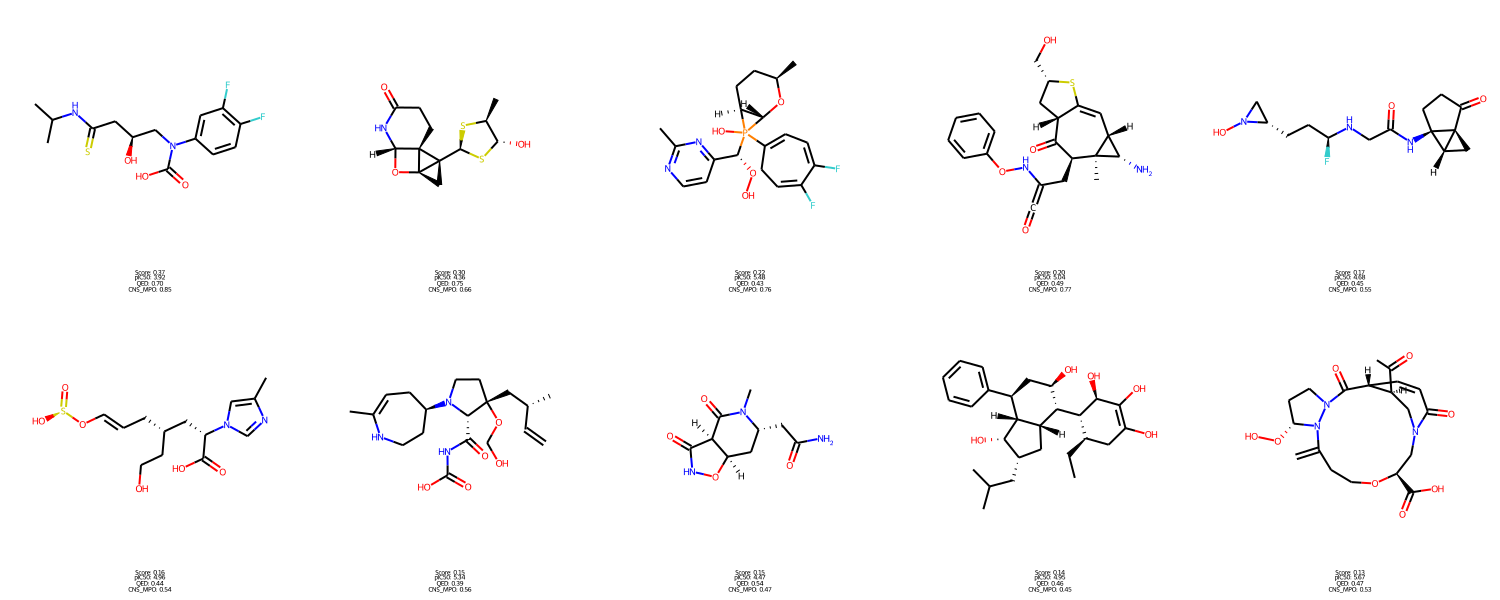

[+] Результаты сохранены в keap1_diffsbdd_hits.csv


In [16]:
# Визуализация топ-молекул
from rdkit.Chem import Draw
from IPython.display import display

def visualize_molecules(df, mols_per_row=5, sub_img_size=(300, 300)):
    """Визуализирует топ-молекулы с их свойствами."""
    mols = [Chem.MolFromSmiles(smile) for smile in df['SMILES']]
    legends = [
        f"Score: {row['Score']:.2f}\npIC50: {row.get('pIC50_KEAP1', 0.0):.2f}\nQED: {row['QED']:.2f}\nCNS_MPO: {row['CNS_MPO']:.2f}"
        for _, row in df.iterrows()
    ]
    img = Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=sub_img_size, legends=legends, useSVG=True)
    display(img)

if not top_molecules.empty:
    print("[*] Визуализация топ-молекул...")
    visualize_molecules(top_molecules)
else:
    print("[!] Нет молекул для визуализации.")

# Ячейка 8: Сохранение результатов (без изменений)
def save_results(df, filename="keap1_diffsbdd_hits.csv"):
    if df.empty:
        print("[!] Нет данных для сохранения.")
        return
    df.to_csv(filename, index=False)
    print(f"[+] Результаты сохранены в {filename}")

if not top_molecules.empty:
    save_results(top_molecules)

In [17]:
# Сохранение результатов
def save_results(df, filename="keap1_diffsbdd_hits_3_sigmoidal.csv"):
    if df.empty:
        print("[!] Нет данных для сохранения.")
        return
    df.to_csv(filename, index=False)
    print(f"[+] Результаты сохранены в {filename}")

if not top_molecules.empty:
    save_results(top_molecules)

[+] Результаты сохранены в keap1_diffsbdd_hits_3_sigmoidal.csv
